# Real NVP

The goal of this notebook is to test the implementation of Real NVP in jax.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
import jax.numpy as jnp
import optax
import sbibm
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

from chainconsumer import ChainConsumer

jax.config.update("jax_enable_x64", True)

2024-02-13 15:48:37.929462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:48:37.929534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:48:37.930451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:48:47.197948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Simulation model

In [2]:
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [3]:
task = sbibm.get_task("gaussian_mixture")
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]

2024-02-13 15:49:08.895771: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas, dtype=np.float64), np.array(self.xs, dtype=np.float64)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [5]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Neural posterior estimation using Real NVP

In [10]:
%load_ext autoreload

%autoreload 2

from normflow.model import AffineCoupling, ConditionalRealNVP
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
bijector_coupling = partial(
    AffineCoupling,
    layers=[128, 128],
    activation=jax.nn.silu
)

In [25]:
NF_nvp = ConditionalRealNVP(
    d=dim,
    n_layers=4,
    bijector_fn=bijector_coupling
)
NF_nvp

ConditionalRealNVP(
    # attributes
    d = 2
    n_layers = 4
    bijector_fn = functools.partial(<class 'normflow.model.AffineCoupling'>, layers=[128, 128], activation=<PjitFunction of <function silu at 0x7fffb28d7b50>>)
)

In [26]:
seed = jax.random.PRNGKey(0)
seed, key = jax.random.split(seed)

params = NF_nvp.init(key, jnp.ones((1, dim)), jnp.ones((1, dim)))

In [27]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)

NF_nvp.apply(params, thetas, xs).shape

(54,)

In [28]:
def loss_nll(params, mu, batch):
    return -jnp.mean(NF_nvp.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    loss, grads = jax.value_and_grad(loss_nll)(params, mu, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [29]:
batch_size = 128
thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)

jax.value_and_grad(loss_nll)(params, jnp.array(thetas), jnp.array(xs))

(Array(14276399.23628493, dtype=float64),
 {'params': {'b0': {'Dense_0': {'bias': Array([-1.8893972e+01, -1.8970406e+04,  1.7555680e+04, -5.2758960e+03,
             7.3749644e+03, -1.4933743e+03, -4.5668007e+01, -2.7935571e+03,
             2.5201402e+04, -1.5948927e+01,  6.5316582e+01, -2.6181873e+03,
             6.8288261e+01, -1.2807999e+04, -1.0052035e+04,  1.8391258e+04,
             2.8321391e+04, -4.5437598e+04,  3.9044625e+04, -1.0592506e+03,
            -6.8372250e+04, -5.4892681e+03, -1.2088999e+03, -7.7694195e+04,
             1.7810182e+03,  1.8357777e+04,  2.0900791e+04,  1.0153406e+04,
            -7.2793755e+03, -5.1160809e+04,  5.7516489e+03,  5.1459094e+04,
            -8.9690762e+03, -7.5325336e+04,  4.7575109e+04, -4.3795642e+02,
             2.6751633e+04, -8.7253496e+03, -1.0648889e+04,  1.3966072e+02,
            -5.1309963e+01,  7.6086431e+00, -3.5488323e+03, -2.1687066e+04,
             9.8911548e+02, -2.2851926e+04,  3.7573471e+01, -1.0471154e+04,
           

In [30]:
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(params)

In [37]:
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(5000))

for batch in pbar:
    thetas = prior(num_samples=batch_size)
    xs = simulator(thetas)
    
    l, params, opt_state = update(
        params, opt_state, jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")

loss 3.609: 100%|██████████| 5000/5000 [00:13<00:00, 359.45it/s] 


In [35]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
num_samples = 10000

sample_nd = NF_nvp.apply(
    params,
    y=observation*jnp.ones((num_samples, 1)),
    num_samples = num_samples,
    key = subkey,
    method = "sample"
)

sample_nd.shape

(10000, 2)

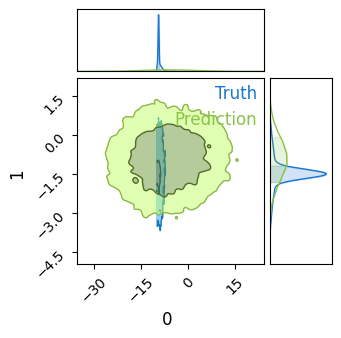

In [36]:
key, subkey = jax.random.split(key)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(sample_nd, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

## Training of the network

In [38]:
bijector_coupling = partial(
    AffineCoupling,
    layers=[128, 128],
    activation=jax.nn.silu
)

class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_data : int,
                 n_layers : int,
                 bijector_fn : callable,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'd': n_data,
                             'n_layers': n_layers,
                             'bijector_fn': bijector_fn
                         },
                         **kwargs)
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def print_tabulate(self, exmp_input):
        pass

    def generate_config(self, logger_params):
        super().generate_config(logger_params)
        sub_model_hparams = self.model_hparams.copy()
        sub_model_hparams['bijector_fn'] = str(sub_model_hparams['bijector_fn'])
        self.config['model_hparams'] = sub_model_hparams

In [42]:
CHECKPOINT_PATH = '~/work/jax/notebooks/checkpoints/'

trainer = RealNVPTrainer(n_data=dim,
                         n_layers=4,
                        bijector_fn=bijector_coupling,
                        optimizer_hparams={'lr': 4e-3},
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)),
                        check_val_every_epoch=5,
                        seed=0)

In [43]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [44]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 1.3731438606098902
Validation loss: 1.4224357073503515
Test loss: 1.4328485600738798


In [45]:
model = trainer.bind_model()

In [46]:
key = jax.random.PRNGKey(42)

samples = model.apply({'params': trainer.state.params}, observation*jnp.ones((10000, 1)), num_samples=10000, key=key, method='sample')

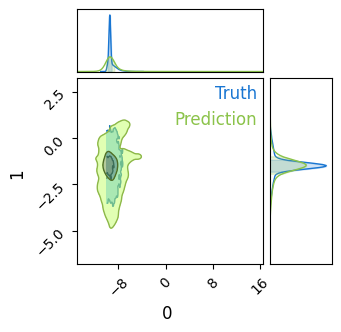

In [47]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [57]:
nvp = model.apply({'params': trainer.state.params}, observation*jnp.ones((1, 1)), method='build_bijector')

In [58]:
bijector = nvp.bijector

In [111]:
observation = observation.astype(jnp.float64)
reference_samples = reference_samples.astype(jnp.float64)
reference_samples = reference_samples.reshape((10000, 1, 2))
reference_samples.shape

(10000, 1, 2)

In [113]:
reference_samples[0]

Array([[-8.15936661, -1.7811439 ]], dtype=float64)

In [103]:
def backward_sample(x):
    return bijector.inverse(x)

In [115]:
backward = jax.vmap(backward_sample)(reference_samples).reshape((10000, 2))

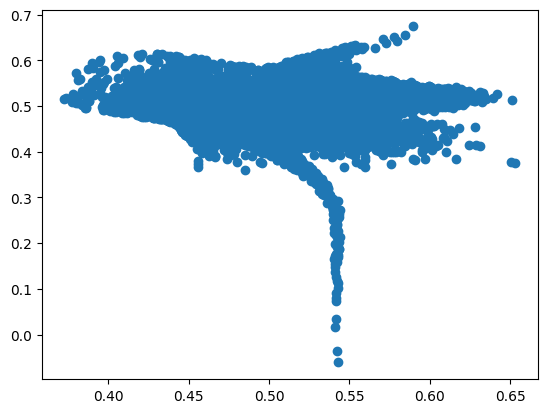

In [116]:
plt.figure()

plt.scatter(backward[:, 0], backward[:, 1], label='Inverse')
plt.show()

In [117]:
samples = samples.reshape((10000, 1, 2))
backward_samples = jax.vmap(backward_sample)(samples).reshape((10000, 2))

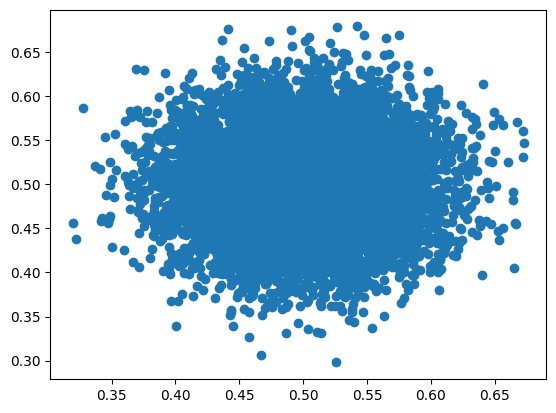

In [118]:
plt.figure()

plt.scatter(backward_samples[:, 0], backward_samples[:, 1], label='Inverse')
plt.show()